In [10]:
# implement  https://pyimagesearch.com/2021/12/01/ocr-passports-with-opencv-and-tesseract/

#from imutils.contours import sort_contours
import numpy as np
import pytesseract
#import imutils
import os
import operator
import cv2
from matplotlib import pyplot as plt

FOLDER = "/Users/chris/Dev/cod_records/aws/extracted/31829_B016711/"
IMAGES = [fp for fp in os.scandir(FOLDER) if fp.name.endswith(".jpg")]

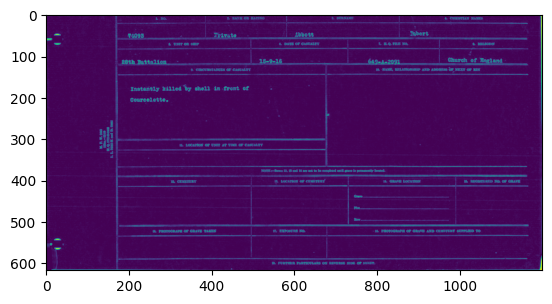

In [11]:
# load the input image, convert it to grayscale, and grab its
# dimensions
image = cv2.imread(IMAGES[2])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 7))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
# smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
plt.imshow(blackhat)

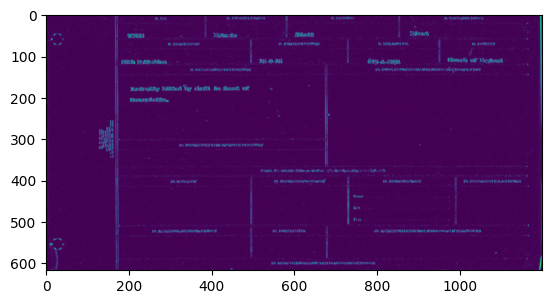

In [12]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
plt.imshow(grad)

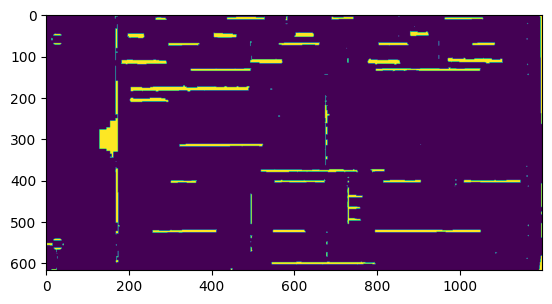

In [13]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [14]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
rects = [cv2.boundingRect(c) for c in cnts]

In [15]:
# use the makers mark on the form to chop off the left margin, it's in the middle of y
img_y_mid = image.shape[0] / 2

for x,y,w,h in sorted(rects, key=lambda r: r[0]):
    if w > 20 and h > 40:
        if y < img_y_mid and (y+h) > img_y_mid:
            margin = x+w
            break

print(margin)

174


In [16]:
# find contours in a row, scanning from top to bottom
# remove contours before the margin or touching the top (damage)
filtered_rects = [r for r in rects if r[0] > margin and r[1] > 0]
# take out small contours
large_rects = [r for r in filtered_rects if r[2] > 4 and r[3] > 4]

top_to_bottom_iter = iter(sorted(large_rects, key=operator.itemgetter(1, 0)))

rows = []
first_rect = next(top_to_bottom_iter)
row = [first_rect]

for rect in top_to_bottom_iter:
    y_mid = first_rect[1] + (first_rect[3] / 2)
    x,y,w,h = rect

    if y < y_mid and (y+h) > y_mid:
        # same row
        row.append(rect)
    else:
        rows.append(row)
        row = [rect]
        first_rect = rect

print(rows)

[[(438, 7, 91, 6), (691, 7, 53, 6), (265, 8, 27, 6), (964, 8, 94, 5)], [(881, 41, 45, 12), (601, 44, 47, 11), (406, 45, 55, 12)], [(197, 47, 41, 11)], [(563, 69, 99, 6), (804, 69, 73, 7), (1031, 69, 55, 6), (296, 70, 75, 6)], [(494, 101, 78, 18), (972, 105, 133, 14), (778, 108, 79, 14)], [(182, 110, 110, 11)], [(798, 128, 253, 10), (350, 131, 146, 6)], [(205, 172, 287, 15)], [(675, 196, 11, 168)], [(203, 202, 93, 10)], [(323, 313, 202, 6)], [(520, 374, 235, 7), (785, 374, 34, 7)], [(553, 398, 123, 8), (816, 400, 91, 6), (1011, 400, 137, 6), (302, 401, 63, 6)], [(729, 418, 37, 88)], [(258, 519, 155, 8), (549, 520, 79, 6), (796, 520, 256, 6)], [(494, 533, 5, 7)]]


(881, 41, 45, 12)



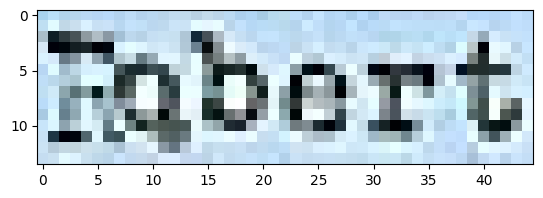

In [17]:
#from myocrfuncs import DIGITS
DIGITS = "-c tessedit_char_whitelist=" + "".join([str(i) for i in range(0, 10)])

service_no_rect = rows[1][0]
print(service_no_rect)
sx, sy, sw, sh = service_no_rect
service_no_img = image[sy-1:sy+sh+1, sx:sx+sw]
plt.imshow(service_no_img)
text = pytesseract.image_to_string(service_no_img, config=f"--psm 8 {DIGITS}")
print(text)

In [18]:
def process(fp):

    # load the input image, convert it to grayscale, and grab its
    # dimensions
    image = cv2.imread(fp)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # initialize a rectangular and square structuring kernel
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))

    # smooth the image using a 3x3 Gaussian blur and then apply a
    # blackhat morpholigical operator to find dark regions on a light
    # background
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")

    # apply a closing operation using the rectangular kernel to close
    # gaps in between letters -- then apply Otsu's thresholding method
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(grad, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    rects = [cv2.boundingRect(c) for c in cnts]

    # use the makers mark on the form to chop off the left margin, it's in the middle of y
    img_y_mid = image.shape[0] / 2

    for x,y,w,h in sorted(rects, key=lambda r: r[0]):
        if w > 20 and h > 40:
            if y < img_y_mid and (y+h) > img_y_mid:
                margin = x+w
                break

    # find contours in a row, scanning from top to bottom
    # remove contours before the margin or touching the top (damage)
    filtered_rects = [r for r in rects if r[0] > margin and r[1] > 0]
    # take out small contours
    large_rects = [r for r in filtered_rects if r[2] > 4 and r[3] > 4]

    top_to_bottom_iter = iter(sorted(large_rects, key=operator.itemgetter(1, 0)))

    rows = []
    first_rect = next(top_to_bottom_iter)
    row = [first_rect]

    for rect in top_to_bottom_iter:
        y_mid = first_rect[1] + (first_rect[3] / 2)
        x,y,w,h = rect

        if y < y_mid and (y+h) > y_mid:
            # same row
            row.append(rect)
        else:
            rows.append(row)
            row = [rect]
            first_rect = rect

    DIGITS = "-c tessedit_char_whitelist=" + "".join([str(i) for i in range(0, 10)])

    service_no_rect = rows[1][0]
    print(service_no_rect)
    sx, sy, sw, sh = service_no_rect
    service_no_img = image[sy-1:sy+sh+1, sx:sx+sw]
    plt.imshow(service_no_img)
    text = pytesseract.image_to_string(service_no_img, config=f"--psm 8 {DIGITS}")
    print(text)